In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

## Przygotowanie danych + Wizualizacja

Załadowanie zbioru danych i podział na zbiory testowy/treningowy. Wizualizacja po redukcji wymiarowości T-SNE

In [2]:
df = pd.read_csv("dataset/diabetes.csv")

In [3]:
y_cols = ["Outcome"]
feature_cols = df.columns.difference(y_cols)
X = df[feature_cols].values
y = df[y_cols].values
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X).astype(np.float32)
X_normalized.shape, y.shape


((768, 8), (768, 1))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=2138)

In [52]:
# 2dim T-SNE
tsne = TSNE(n_components=2, random_state=1356)
vis_points = tsne.fit_transform(X_train)

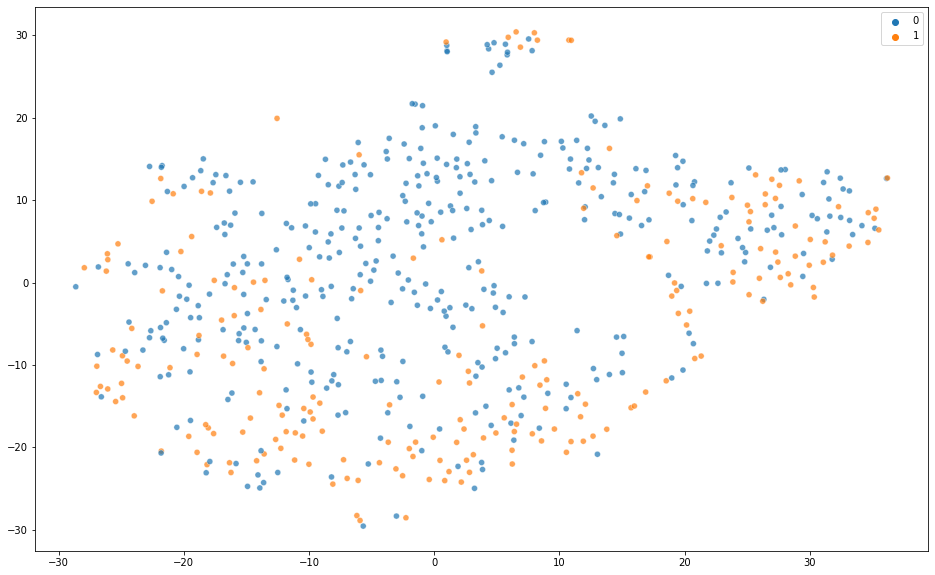

In [53]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=vis_points[:,0], y=vis_points[:,1], hue=y_train.ravel(), legend="full", alpha=0.7
)
plt.show()

In [47]:
# 3dim T-SNE
tsne = TSNE(n_components=3, random_state=1337)
vis_points = tsne.fit_transform(X_train)

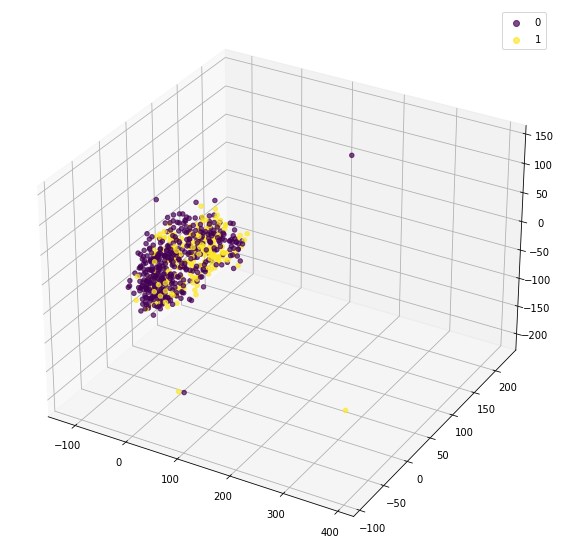

In [48]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(vis_points[:, 0], vis_points[:, 1], vis_points[:, 2], c=y_train, marker='o', alpha=0.7)
plt.legend(*sc.legend_elements())
plt.show()

## GMM 

### Podejscie pierwsze 

2 składowe odpowiadające klasom

In [5]:
from src.gmm import GaussianMixtureModel, GaussianMixtureModelKMeans

  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.


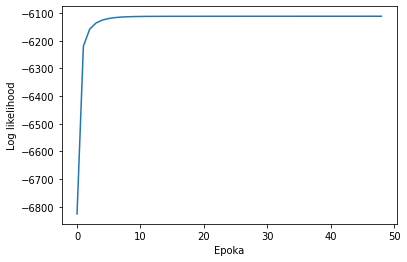

In [39]:
k = 2
n_dims = X_train.shape[1]
model = GaussianMixtureModelKMeans(n_components = k, n_dims = n_dims, n_epochs=100)
model.fit(X_train, random_state=42)

In [40]:
y_pred_probs = model.predict(X_test.astype(np.float32)).numpy()
# potrzeba sprawdzic 2 przypadki, bo nie wiemy które klastry odpowiadają której klasie
y_pred_1 = np.argmax(y_pred_probs, axis=1)
y_pred_2 = np.argmax(np.flip(y_pred_probs, axis=1), axis=1)

In [41]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.48      0.37      0.42        99
           1       0.19      0.27      0.23        55

    accuracy                           0.34       154
   macro avg       0.34      0.32      0.32       154
weighted avg       0.38      0.34      0.35       154



In [42]:
print(classification_report(y_test, y_pred_2)) # <- to musi byc to

              precision    recall  f1-score   support

           0       0.81      0.63      0.70        99
           1       0.52      0.73      0.61        55

    accuracy                           0.66       154
   macro avg       0.66      0.68      0.66       154
weighted avg       0.70      0.66      0.67       154



#### Cluster visualization

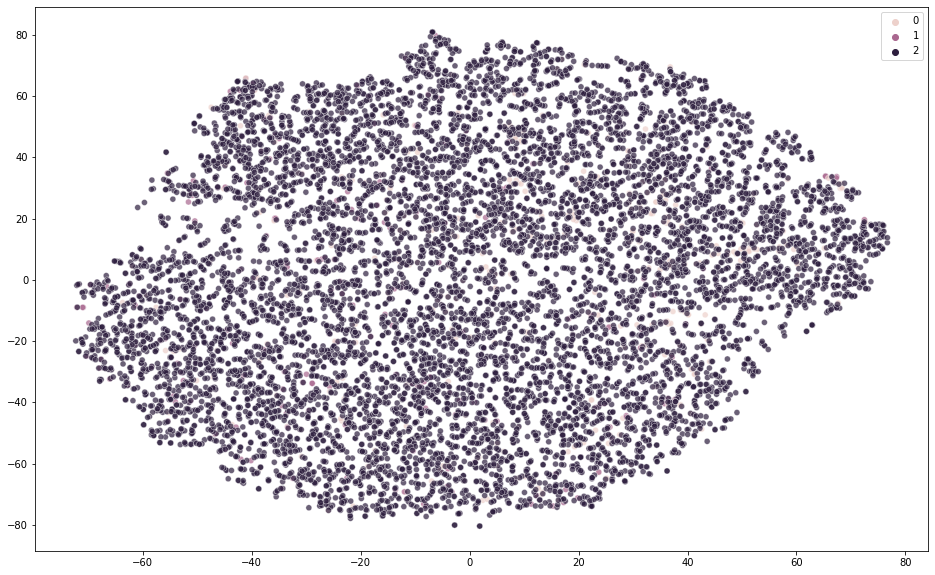

In [56]:
data = X_train
labels = y_train

n_sample = 10000
samples = []
for i in range(n_sample):
    samples.append(model.sample())
samples = np.vstack(samples)

data = np.vstack((data, samples))
labels = np.vstack((labels, np.full((n_sample, 1), 2)))

tsne = TSNE(n_components=2, random_state=1356)
vis_points = tsne.fit_transform(data)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=vis_points[:,0], y=vis_points[:,1], hue=labels.ravel(), legend="full", alpha=0.7
)
plt.show()

### Podejscie drugie 

klasteryzacja danych poszczególnych klas osobno

In [13]:
n_dims = X_train.shape[1]
y_train_flat = y_train.ravel()
X_train_y1 = X_train[y_train_flat == 0]
X_train_y2 = X_train[y_train_flat == 1]
len(X_train_y1), len(X_train_y2)

(401, 213)

#### Znajdz najlepszą liczbę komponentów k

In [9]:
# Znajdz najlepszą liczbę komponentów
def find_best_k(data, max_k = 20):
    n_dims = data.shape[1]
    
    log_dict = {"components": [], "aic": [], "bic": [], "log_likelihood": []}
    for k in range(1, max_k + 1):
        print(f"Training for {k} components")
        try:
            model = GaussianMixtureModelKMeans(n_components = k, n_dims=n_dims, n_epochs=100, verbose=False)
            model.fit(data, random_state=65)
            log_dict["components"].append(k)
            log_dict["log_likelihood"].append(data.shape[0] * max(model.history["log_likelihood"]))
            log_dict["aic"].append(model.aic(data))
            log_dict["bic"].append(model.bic(data))
        except Exception as e:
            print(f"Exception during training: {e}")
    df = pd.DataFrame(log_dict)
    df.plot("components", ["aic", "bic", "log_likelihood"])
    plt.show()
    
    return df

Training for 1 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 2 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 3 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 4 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 5 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 6 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 7 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 8 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 9 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 10 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 11 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 12 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 13 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 14 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 15 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 16 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 17 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 18 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 19 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 20 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite


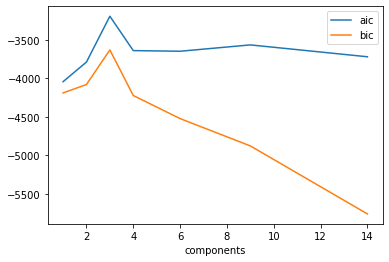

,components,aic,bic,log_likelihood
0,1,-4041.895143,-4187.674736,"tensor(-1591526.9525, dtype=torch.float64)"
1,2,-3786.615658,-4078.174842,"tensor(-1459886.8790, dtype=torch.float64)"
2,3,-3191.614889,-3628.953665,"tensor(-1027409.8729, dtype=torch.float64)"
3,4,-3637.845443,-4220.963811,"tensor(-1296093.2873, dtype=torch.float64)"
4,6,-3646.196754,-4520.874306,"tensor(-1246060.0298, dtype=torch.float64)"
5,9,-3563.791901,-4875.808230,"tensor(-1078301.8231, dtype=torch.float64)"
6,14,-3717.884712,-5758.799002,"tensor(-804516.0432, dtype=torch.float64)"


In [10]:
find_best_k(X_train_y1)

Training for 1 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 2 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 3 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 4 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 5 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 6 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 7 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 8 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 9 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 10 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 11 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 12 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 13 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 14 components


  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.
Training for 15 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 16 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 17 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 18 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 19 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite
Training for 20 components


  0%|          | 0/100 [00:00<?, ?it/s]

Exception during training: the input matrix must be positive semidefinite


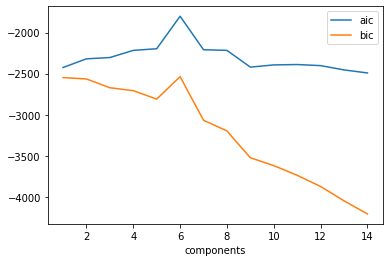

,components,aic,bic,log_likelihood
0,1,-2425.297164,-2547.984328,"tensor(-501039.2958, dtype=torch.float64)"
1,2,-2319.691023,-2565.065351,"tensor(-381324.3006, dtype=torch.float64)"
2,3,-2303.827912,-2671.889404,"tensor(-373276.3910, dtype=torch.float64)"
3,4,-2216.805829,-2707.554485,"tensor(-298350.2921, dtype=torch.float64)"
4,5,-2196.865283,-2810.301104,"tensor(-358174.3634, dtype=torch.float64)"
5,6,-1800.878690,-2537.001674,"tensor(-288510.6299, dtype=torch.float64)"
6,7,-2208.905409,-3067.715557,"tensor(-349118.1881, dtype=torch.float64)"
7,8,-2216.740441,-3198.237753,"tensor(-322346.0259, dtype=torch.float64)"
8,9,-2420.803336,-3524.987813,"tensor(-319007.7561, dtype=torch.float64)"
9,10,-2393.880780,-3620.752421,"tensor(-338356.4719, dtype=torch.float64)"


In [11]:
find_best_k(X_train_y2)

#### Trening używając znalezionych k

In [12]:
# best k's
k_y1 = 3
k_y2 = 6

In [16]:
model_y1 = GaussianMixtureModelKMeans(n_components=k_y1, n_dims=n_dims, n_epochs=100)
model_y2 = GaussianMixtureModelKMeans(n_components=k_y2, n_dims=n_dims, n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.


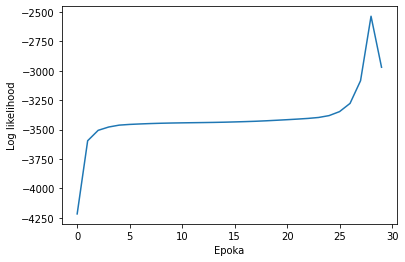

In [17]:
model_y1.fit(X_train_y1)

  0%|          | 0/100 [00:00<?, ?it/s]

Log likelihood not increasing, stopping.


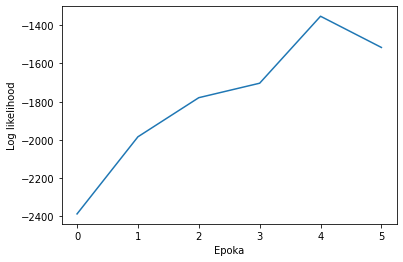

In [18]:
model_y2.fit(X_train_y2)

In [33]:
y_pred_probs_y1 = model_y1.predict(X_test).numpy()
y_pred_probs_y2 = model_y2.predict(X_test).numpy()
np.hstack((y_pred_probs_y1, y_pred_probs_y2))

array([[1.00000000e+00, 0.00000000e+00, 1.13374975e-32, ...,
        0.00000000e+00, 1.30569907e-02, 0.00000000e+00],
       [1.79797702e-03, 9.98202026e-01, 4.29339723e-12, ...,
        0.00000000e+00, 6.45038502e-18, 9.99997675e-01],
       [3.02241134e-15, 1.00000000e+00, 2.62867907e-13, ...,
        9.99999940e-01, 7.96084281e-13, 6.20054408e-08],
       ...,
       [2.84408629e-01, 0.00000000e+00, 7.15591431e-01, ...,
        0.00000000e+00, 3.97529313e-03, 0.00000000e+00],
       [5.71234996e-05, 9.99942839e-01, 3.50216648e-14, ...,
        0.00000000e+00, 6.41371312e-09, 9.99999225e-01],
       [2.62282236e-04, 9.99737680e-01, 6.90868982e-22, ...,
        0.00000000e+00, 5.88716956e-27, 9.99999821e-01]], dtype=float32)

In [34]:
y_pred_probs_y1 = y_pred_probs_y1.max(axis=1)
y_pred_probs_y2 = y_pred_probs_y2.max(axis=1)
y_pred = (y_pred_probs_y2 > y_pred_probs_y1) * np.ones((X_test.shape[0]))

In [38]:
np.column_stack((y_pred_probs_y1, y_pred_probs_y2))

array([[1.        , 0.9868138 ],
       [0.998202  , 0.9999977 ],
       [1.        , 0.99999994],
       [0.9970897 , 0.99998075],
       [1.        , 0.904151  ],
       [1.        , 0.99999994],
       [0.9979699 , 0.99889934],
       [1.        , 0.9998641 ],
       [0.996522  , 0.999244  ],
       [0.9984126 , 0.9999933 ],
       [1.        , 0.74193615],
       [0.9976052 , 0.87569046],
       [1.        , 0.9994491 ],
       [0.9334919 , 0.775058  ],
       [0.9994427 , 0.9983218 ],
       [0.87933904, 0.9991327 ],
       [0.99999493, 0.99999994],
       [0.9925096 , 0.9999995 ],
       [0.9999913 , 0.9999996 ],
       [0.99987555, 0.99999994],
       [0.99936503, 0.99998313],
       [0.98355883, 0.99994636],
       [1.        , 1.        ],
       [0.99999034, 0.9999994 ],
       [0.9999928 , 0.9999996 ],
       [0.99014294, 0.9886458 ],
       [0.99744976, 0.9998787 ],
       [0.84731865, 0.5616517 ],
       [0.99995166, 0.80310446],
       [0.9834489 , 0.9999887 ],
       [0.

In [35]:
y_pred

array([0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
       1.])

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.42      0.47        99
           1       0.23      0.31      0.26        55

    accuracy                           0.38       154
   macro avg       0.38      0.37      0.37       154
weighted avg       0.42      0.38      0.40       154

